## Configurando ambiente do Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [3]:
!kaggle competitions download -c classificandos-nuvens-usando-cnn

classificandos-nuvens-usando-cnn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

file_path = '/content/classificandos-nuvens-usando-cnn.zip'
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [57]:
import pandas as pd
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models

## Definindo Dataset

In [6]:
class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # get image path and label
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            print(f'\tAmostras na classe {class_name}:{len(os.listdir(class_dir))}')
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Importando dados

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 8

In [8]:
print('Treino:')
train_dataset = CloudDataset(root_dir='/content/drive/MyDrive/kaggle/clouds/clouds_train', transform=transform)
print('Teste:')
test_dataset = CloudDataset(root_dir='/content/drive/MyDrive/kaggle/clouds/clouds_test', transform=transform)
print(f'Amostrar dataset de treino: {len(train_dataset)}')
print(f'Amostrar dataset de teste: {len(test_dataset)}') # dados desbalanceados
# oxi por que tem mais amostras no teste do que no treino?

Treino:
	Amostras na classe cirriform clouds:66
	Amostras na classe clear sky:60
	Amostras na classe cumulonimbus clouds:14
	Amostras na classe cumulus clouds:91
	Amostras na classe high cumuliform clouds:133
	Amostras na classe stratiform clouds:49
	Amostras na classe stratocumulus clouds:61
Teste:
	Amostras na classe cirriform clouds:77
	Amostras na classe clear sky:64
	Amostras na classe cumulonimbus clouds:11
	Amostras na classe cumulus clouds:120
	Amostras na classe high cumuliform clouds:103
	Amostras na classe stratiform clouds:40
	Amostras na classe stratocumulus clouds:71
Amostrar dataset de treino: 474
Amostrar dataset de teste: 486


In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
print(train_dataset.classes)

['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


## Definindo o modelo

In [54]:
class MultiClassCNN(nn.Module):
    def __init__(self, n_classes):
        super(MultiClassCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # adicionado apos overfitting
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),  # adicionado apos overfitting
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # adicionado apos overfitting
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## Definindo treinamento e validação

In [55]:
def train(model, train_loader, test_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    list_tloss = []
    list_vloss = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        mean_vloss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        model.eval()
        with torch.no_grad():
            for vimg, vlabel in test_loader:
                vimg, vlabel = vimg.to(device), vlabel.to(device)
                voutputs = model(vimg)
                vloss = criterion(voutputs, vlabel)
                mean_vloss += vloss.item()

        mean_loss = total_loss/len(train_loader)
        mean_vloss /= len(test_loader)

        list_tloss.append(mean_loss)
        list_vloss.append(mean_vloss)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"\tLoss: {mean_loss:.3f}")
        print(f"\tEval Loss: {mean_vloss:.3f}")
        print(f"\tAccuracy: {correct/total:.3f}")

    plt.plot(list_tloss, 'b', label='Train Loss')
    plt.plot(list_vloss, 'r', label='Validation Loss')
    plt.show()


def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Eval Accuracy: {correct/total:.3f}")

## Treinando

Epoch 1/100:
	Loss: 20.499
	Eval Loss: 2.036
	Accuracy: 0.245
Epoch 2/100:
	Loss: 1.954
	Eval Loss: 1.803
	Accuracy: 0.295
Epoch 3/100:
	Loss: 1.919
	Eval Loss: 1.802
	Accuracy: 0.325
Epoch 4/100:
	Loss: 1.859
	Eval Loss: 1.749
	Accuracy: 0.344
Epoch 5/100:
	Loss: 1.788
	Eval Loss: 1.774
	Accuracy: 0.344
Epoch 6/100:
	Loss: 1.821
	Eval Loss: 1.741
	Accuracy: 0.335
Epoch 7/100:
	Loss: 1.901
	Eval Loss: 1.778
	Accuracy: 0.323
Epoch 8/100:
	Loss: 1.891
	Eval Loss: 1.699
	Accuracy: 0.302
Epoch 9/100:
	Loss: 1.826
	Eval Loss: 1.699
	Accuracy: 0.310
Epoch 10/100:
	Loss: 1.848
	Eval Loss: 1.685
	Accuracy: 0.319
Epoch 11/100:
	Loss: 1.778
	Eval Loss: 1.746
	Accuracy: 0.321
Epoch 12/100:
	Loss: 1.768
	Eval Loss: 1.650
	Accuracy: 0.319
Epoch 13/100:
	Loss: 1.746
	Eval Loss: 1.677
	Accuracy: 0.327
Epoch 14/100:
	Loss: 1.737
	Eval Loss: 1.637
	Accuracy: 0.335
Epoch 15/100:
	Loss: 1.771
	Eval Loss: 1.666
	Accuracy: 0.316
Epoch 16/100:
	Loss: 1.812
	Eval Loss: 1.708
	Accuracy: 0.300
Epoch 17/100:
	L

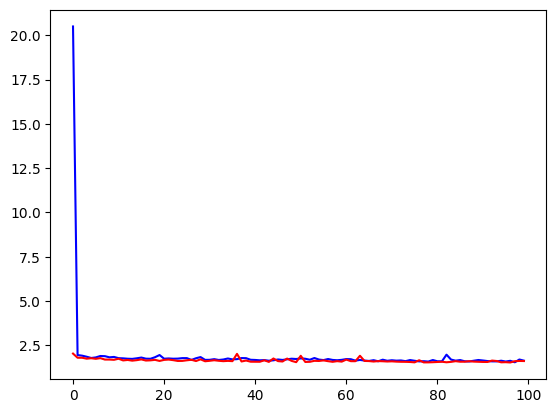

Eval Accuracy: 0.321


In [56]:
num_classes = len(train_dataset.classes)

model = MultiClassCNN(num_classes)
train(model, train_loader, test_loader, epochs=100)
evaluate(model, test_loader)

torch.save(model.state_dict(), "simple_cloud_cnn.pth")

ô gente mas meu bichin rodou ruim dms coitado kkkkk

## Transfer Learing com pytorch

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


Epoch 1/100:
	Loss: 1.317
	Eval Loss: 3.023
	Accuracy: 0.561
Epoch 2/100:
	Loss: 0.858
	Eval Loss: 2.421
	Accuracy: 0.705
Epoch 3/100:
	Loss: 0.855
	Eval Loss: 0.933
	Accuracy: 0.696
Epoch 4/100:
	Loss: 0.756
	Eval Loss: 0.833
	Accuracy: 0.743
Epoch 5/100:
	Loss: 0.642
	Eval Loss: 1.911
	Accuracy: 0.772
Epoch 6/100:
	Loss: 0.698
	Eval Loss: 0.602
	Accuracy: 0.764
Epoch 7/100:
	Loss: 0.669
	Eval Loss: 0.542
	Accuracy: 0.766
Epoch 8/100:
	Loss: 0.646
	Eval Loss: 0.565
	Accuracy: 0.797
Epoch 9/100:
	Loss: 0.537
	Eval Loss: 0.575
	Accuracy: 0.816
Epoch 10/100:
	Loss: 0.437
	Eval Loss: 0.429
	Accuracy: 0.840
Epoch 11/100:
	Loss: 0.392
	Eval Loss: 0.589
	Accuracy: 0.852
Epoch 12/100:
	Loss: 0.285
	Eval Loss: 0.601
	Accuracy: 0.903
Epoch 13/100:
	Loss: 0.491
	Eval Loss: 0.683
	Accuracy: 0.848
Epoch 14/100:
	Loss: 0.515
	Eval Loss: 0.704
	Accuracy: 0.812
Epoch 15/100:
	Loss: 0.352
	Eval Loss: 0.368
	Accuracy: 0.867
Epoch 16/100:
	Loss: 0.402
	Eval Loss: 0.546
	Accuracy: 0.873
Epoch 17/100:
	Lo

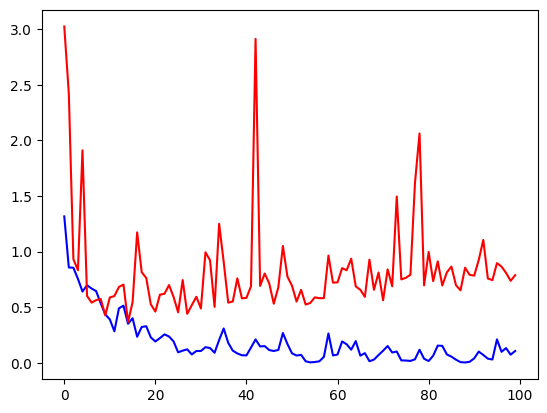

Eval Accuracy: 0.833


In [58]:
# https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes) # modificando para o numero de features

model = resnet18

train(model, train_loader, test_loader, epochs=100)
evaluate(model, test_loader)

torch.save(model.state_dict(), "transfer_learning_cloud_cnn.pth")

afff deu de 10 a zero no meu